# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

J:\ANACONDA3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
# using SQLite Table to read data.
con = sqlite3.connect(r'C:\Users\welcome\Downloads\amazon-fine-food-reviews/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (5000, 10)


Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      1  1303862400   
1                     0                       0      0  1346976000   
2                     1                       1      1  1219017600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...

In [4]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


UserId   ProductId             ProfileName        Time  Score  \
0  #oc-R115TNMSPFT9I7  B007Y59HVM                 Breyton  1331510400      2   
1  #oc-R11D9D7SHXIJB9  B005HG9ET0  Louis E. Emory "hoppy"  1342396800      5   
2  #oc-R11DNU2NBKQ23Z  B007Y59HVM        Kim Cieszykowski  1348531200      1   
3  #oc-R11O5J5ZVQE25C  B005HG9ET0           Penguin Chick  1346889600      5   
4  #oc-R12KPBODL2B5ZD  B007OSBE1U   Christopher P. Presta  1348617600      1   

                                                Text  COUNT(*)  
0  Overall its just OK when considering the price...         2  
1  My wife has recurring extreme muscle spasms, u...         3  
2  This coffee is horrible and unfortunately not ...         2  
3  This will be the bottle that you grab from the...         3  
4  I didnt like this coffee. Instead of telling y...         2

In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

UserId   ProductId                      ProfileName        Time  \
80638  AZY10LLTJ71NX  B006P7E5ZI  undertheshrine "undertheshrine"  1334707200   

       Score                                               Text  COUNT(*)  
80638      5  I was recommended to try green tea extract to ...         5

In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

Id   ProductId         UserId      ProfileName  HelpfulnessNumerator  \
0   78445  B000HDL1RQ  AR5J8UI46CURR  Geetha Krishnan                     2   
1  138317  B000HDOPYC  AR5J8UI46CURR  Geetha Krishnan                     2   
2  138277  B000HDOPYM  AR5J8UI46CURR  Geetha Krishnan                     2   
3   73791  B000HDOPZG  AR5J8UI46CURR  Geetha Krishnan                     2   
4  155049  B000PAQ75C  AR5J8UI46CURR  Geetha Krishnan                     2   

   HelpfulnessDenominator  Score        Time  \
0                       2      5  1199577600   
1                       2      5  1199577600   
2                       2      5  1199577600   
3                       2      5  1199577600   
4                       2      5  1199577600   

                             Summary  \
0  LOACKER QUADRATINI VANILLA WAFERS   
1  LOACKER QUADRATINI VANILLA WAFERS   
2  LOACKER QUADRATINI VANILLA WAFERS   
3  LOACKER QUADRATINI VANILLA WAFERS   
4  LOACKER QUADRATINI VANILLA WAFERS   

                                                Text  
0  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
1  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
2  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
3  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
4  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

Id   ProductId          UserId              ProfileName  \
0  64422  B000MIDROQ  A161DK06JJMCYF  J. E. Stephens "Jeanne"   
1  44737  B001EQ55RW  A2V0I904FH7ABY                      Ram   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     3                       1      5  1224892800   
1                     3                       2      4  1212883200   

                                        Summary  \
0             Bought This for My Son at College   
1  Pure cocoa taste with crunchy almonds inside   

                                                Text  
0  My son loves spaghetti so I didn't hesitate or...  
1  It was almost a 'love at first bite' - the per...

In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(4986, 10)


1    4178
0     808
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no 

In [16]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [17]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I'm sorry; b

In [18]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you do not like that combination, do not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I do not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They are not individually wrapped, which would add to the cost.  Oh y

In [20]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [21]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews do nobody any good beyond reminding us to look before ordering br br These are chocolate oatmeal cookies If you do not like that combination do not order this type of cookie I find the combo quite nice really The oatmeal sort of calms the rich chocolate flavor and gives the cookie sort of a coconut type consistency Now let is also remember that tastes differ so I have given my opinion br br Then these are soft chewy cookies as advertised They are not crispy cookies or the blurb would say crispy rather than chewy I happen to like raw cookie dough however I do not see where these taste like raw cookie dough Both are soft however so is this the confusion And yes they stick together Soft cookies tend to do that They are not individually wrapped which would add to the cost Oh yeah chocolate chip cookies tend to be somewhat sweet br br So if you wa

In [90]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself','not' \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:05<00:00, 858.47it/s]


In [23]:
preprocessed_reviews[1500]

'wow far two two star reviews one obviously no idea ordering wants crispy cookies hey sorry reviews nobody good beyond reminding us look ordering chocolate oatmeal cookies not like combination not order type cookie find combo quite nice really oatmeal sort calms rich chocolate flavor gives cookie sort coconut type consistency let also remember tastes differ given opinion soft chewy cookies advertised not crispy cookies blurb would say crispy rather chewy happen like raw cookie dough however not see taste like raw cookie dough soft however confusion yes stick together soft cookies tend not individually wrapped would add cost oh yeah chocolate chip cookies tend somewhat sweet want something hard crisp suggest nabiso ginger snaps want cookie soft chewy tastes like combination chocolate oatmeal give try place second order'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [6]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [79]:
#BoW
count_vect_ = CountVectorizer() #in scikit-learn
count_vect_.fit(preprocessed_reviews)
print("some feature names ", count_vect_.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words  3144


## [4.2] Bi-Grams and n-Grams.

In [25]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [26]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.4] Word2Vec

In [27]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [28]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('excellent', 0.9937706589698792), ('hull', 0.9929193258285522), ('think', 0.9927008152008057), ('want', 0.9925186038017273), ('snack', 0.9924747943878174), ('likes', 0.992378830909729), ('healthy', 0.9920475482940674), ('looking', 0.9919270277023315), ('especially', 0.9918246269226074), ('feel', 0.9916783571243286)]
[('gross', 0.9992587566375732), ('varieties', 0.9992384910583496), ('wow', 0.9992378950119019), ('must', 0.9992377161979675), ('uses', 0.9992157816886902), ('normal', 0.9992148876190186), ('miss', 0.9992107152938843), ('type', 0.9991928339004517), ('asked', 0.9991909861564636), ('style', 0.9991798400878906)]


In [29]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [30]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:13<00:00, 368.18it/s]


4986
50


#### [4.4.1.2] TFIDF weighted W2v

In [31]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [32]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████████| 4986/4986 [01:23<00:00, 59.94it/s]


# [5] Assignment 10: K-Means, Agglomerative & DBSCAN Clustering

<ol>
    <li><strong>Apply K-means Clustering on these feature sets:</strong>
        <ul>
    <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘k’ using the elbow-knee method (plot k vs inertia_)</li>
    <li>Once after you find the k clusters, plot the word cloud per each cluster so that at a single
go we can analyze the words in a cluster.</li>          
        </ul>
    </li>
    <br>
    <li><strong>Apply Agglomerative Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Apply agglomerative algorithm and try a different number of clusters like 2,5 etc.</li>
    <li>Same as that of K-means, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews or so(as this is very computationally expensive one)</li>
        </ul>
    </li>
    <br>
    <br>
    <li><strong>Apply DBSCAN Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘Eps’ using the <a href='https://stackoverflow.com/questions/12893492/choosing-eps-and-minpts-for-dbscan-r/48558030#48558030'>elbow-knee method.</a></li>
    <li>Same as before, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews for this as well.</li>
        </ul>
    </li>
</ol>

## [5.1] K-Means Clustering

### [5.1.1] Applying K-Means Clustering on BOW,<font color='red'> SET 1</font>

In [33]:
from sklearn.cluster import KMeans
cluster_range = range( 1, 20)
cluster_errors = []

for num_clusters in cluster_range:
    clusters = KMeans( num_clusters,n_init=5,n_jobs=-1)
    clusters.fit( final_counts )
    print('for k',num_clusters,'intertia', clusters.inertia_ )
    cluster_errors.append( clusters.inertia_ )

for k 1 intertia 265215.63217007613
for k 2 intertia 257021.93814810578
for k 3 intertia 254286.26297268036
for k 4 intertia 251385.45827862117
for k 5 intertia 249178.7440301044
for k 6 intertia 247485.94982491803
for k 7 intertia 246421.20065739006
for k 8 intertia 245871.29355148203
for k 9 intertia 242297.8433649015
for k 10 intertia 241174.41607907435
for k 11 intertia 240563.93171112117
for k 12 intertia 240621.40344224856
for k 13 intertia 238443.1126979358
for k 14 intertia 236749.51019261914
for k 15 intertia 237667.80799775277
for k 16 intertia 235958.70818550748
for k 17 intertia 233446.99619670736
for k 18 intertia 234140.79214363825
for k 19 intertia 233103.35245079023


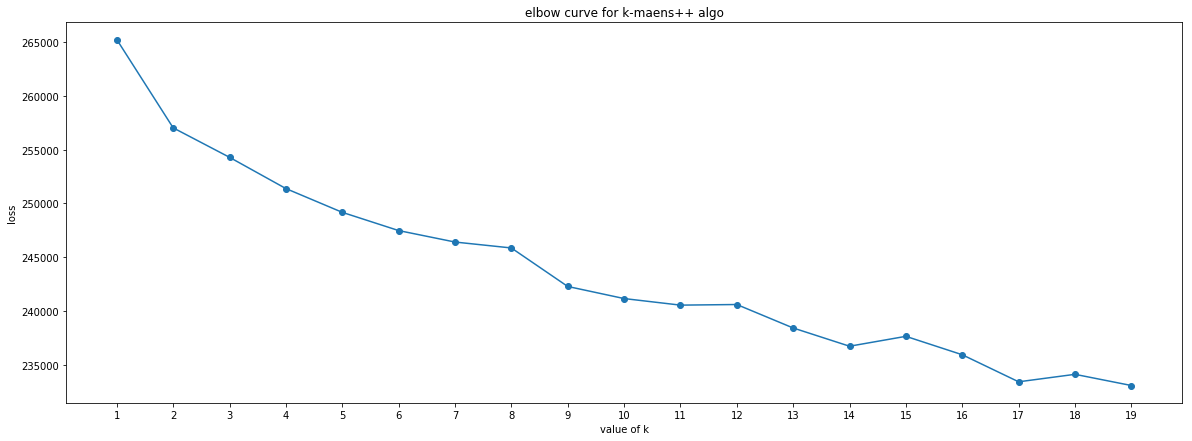

In [34]:
#ploting the inetria vs k
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20,7))
plt.plot( list(range(1,20)), clusters_df.cluster_errors, marker = "o" )
plt.xticks(list(range(1,20)))
plt.title('elbow curve for k-maens++ algo')
plt.xlabel('value of k')
plt.ylabel('loss')
plt.show()

By looking above plot we can take 8 as number cluster

In [73]:
k = KMeans(n_clusters=8, random_state = 0).fit(final_counts)

### [5.1.2] Wordclouds of clusters obtained after applying k-means on BOW<font color='red'> SET 1</font>

In [110]:
#function to print imo words
from wordcloud import WordCloud
def print_words(words):
    
    wordcloud = WordCloud(background_color='white',
                          width=2000,
                          height=1800,stopwords = stopwords
                         ).generate(words)
    plt.figure(figsize=(8,8))

    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

Top terms per cluster:
Cluster 0:
 not
 like
 would
 one
 good
 product
 taste
 no
 make
 get
 use
 sugar
 flavor
 much
 also
 really
 mix
 water
 chocolate
 even


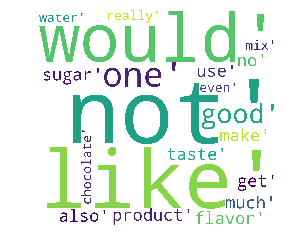


Cluster 1:
 not
 good
 like
 product
 love
 flavor
 one
 best
 taste
 would
 chips
 no
 amazon
 find
 buy
 get
 really
 tried
 coffee
 use


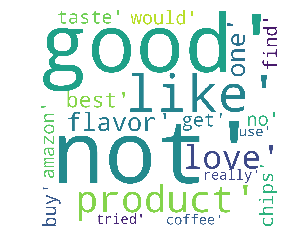


Cluster 2:
 tea
 not
 green
 like
 water
 taste
 flavor
 one
 good
 drink
 teas
 use
 would
 sweet
 bag
 tried
 iced
 love
 sugar
 drinking


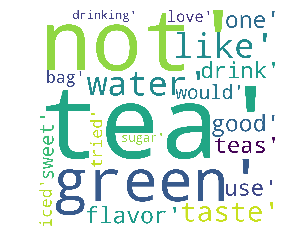


Cluster 3:
 food
 dog
 not
 one
 newman
 would
 dogs
 organic
 like
 no
 eat
 bag
 old
 foods
 good
 cat
 cats
 much
 well
 also


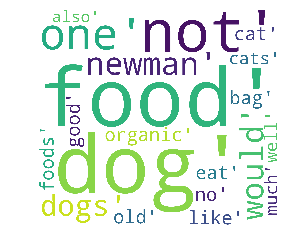


Cluster 4:
 chips
 not
 kettle
 potato
 bag
 like
 brand
 salt
 bags
 also
 flavor
 taste
 would
 good
 flavors
 vinegar
 bbq
 chip
 much
 amazon


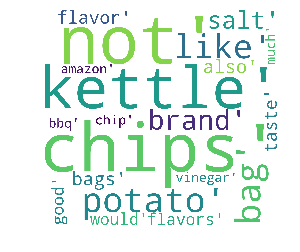


Cluster 5:
 coffee
 not
 cup
 taste
 like
 good
 decaf
 flavor
 one
 would
 melitta
 drink
 get
 bag
 really
 water
 cups
 strong
 even
 dark


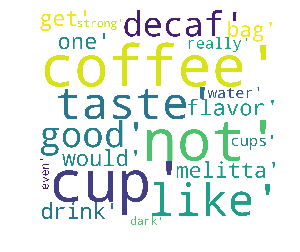


Cluster 6:
 not
 like
 good
 taste
 one
 would
 flavor
 chips
 product
 really
 great
 love
 get
 much
 tried
 best
 time
 no
 try
 mix


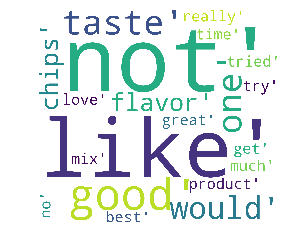


Cluster 7:
 great
 not
 product
 taste
 chips
 love
 good
 like
 flavor
 price
 one
 use
 no
 little
 really
 would
 amazon
 find
 buy
 coffee


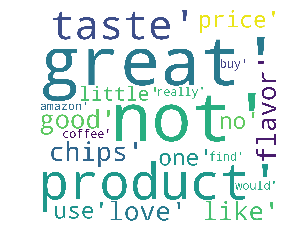

In [93]:
#taking top 20 words in each cluster
print("Top terms per cluster:")
order_centroids = k.cluster_centers_.argsort()[:, ::-1]
terms = count_vect_.get_feature_names()
for i in range(8):
    print ("Cluster %d:" % i)
    words= []
    for ind in order_centroids[i, :20]:
        print (' %s' % terms[ind])
        words.append(terms[ind])
    print_words(str(words))
        
    print()

By looking above word clouds we can say we are geeting some what good seperation like in cluster3 we are getting  about animals like dogs and cats,cluster 4 we are getting abput chips pottatos and in cluster 5 we are getting about cofee

### [5.1.3] Applying K-Means Clustering on TFIDF,<font color='red'> SET 2</font>

In [94]:
# Please write all the code with proper documentation
from sklearn.cluster import KMeans
cluster_range = range( 1, 20)
cluster_errors = []

for num_clusters in cluster_range:
    clusters = KMeans( num_clusters,n_init=5,n_jobs=-1)
    clusters.fit( final_tf_idf )
    print('for k',num_clusters,'intertia', clusters.inertia_ )
    cluster_errors.append( clusters.inertia_ )

for k 1 intertia 4848.025152702605
for k 2 intertia 4815.948199858234
for k 3 intertia 4784.999202003066
for k 4 intertia 4760.346392474664
for k 5 intertia 4729.170745427583
for k 6 intertia 4705.278509153741
for k 7 intertia 4694.252290299512
for k 8 intertia 4671.542017880983
for k 9 intertia 4661.059532394875
for k 10 intertia 4654.205600594097
for k 11 intertia 4642.013224618644
for k 12 intertia 4631.54814742728
for k 13 intertia 4626.092326232731
for k 14 intertia 4614.852220720105
for k 15 intertia 4607.292715756882
for k 16 intertia 4594.94782879281
for k 17 intertia 4593.116386631165
for k 18 intertia 4585.3850042409895
for k 19 intertia 4574.880619418393


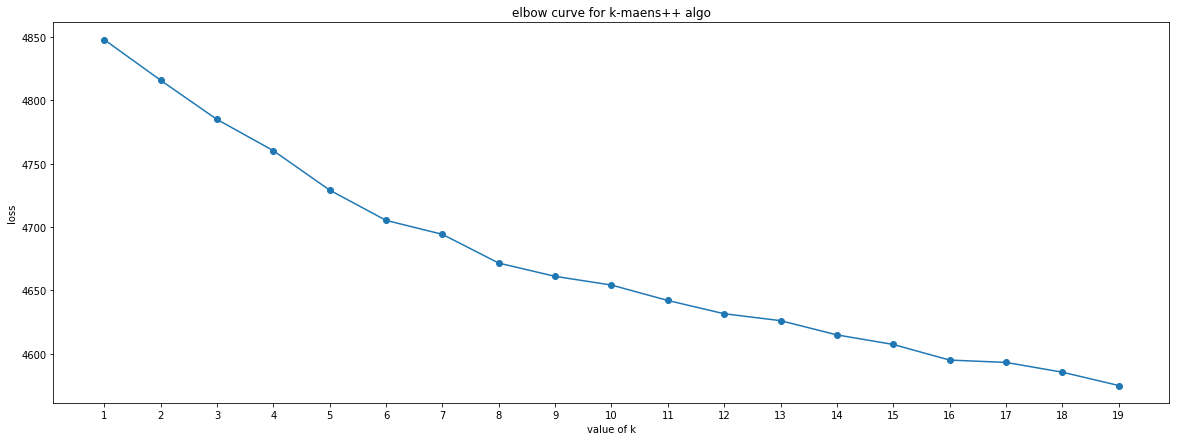

In [96]:
clusters_df_ = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20,7))
plt.plot( list(range(1,20)), clusters_df_.cluster_errors, marker = "o" )
plt.xticks(list(range(1,20)))
plt.title('elbow curve for k-maens++ algo')
plt.xlabel('value of k')
plt.ylabel('loss')
plt.show()

Taking 7 as number clusters

In [97]:
k_ = KMeans(n_clusters=7, random_state = 0).fit(final_tf_idf)

### [5.1.4] Wordclouds of clusters obtained after applying k-means on TFIDF<font color='red'> SET 2</font>

Top terms per cluster:
Cluster 0:
 gluten
 gluten free
 mix
 pancakes
 free
 bisquick
 waffles
 pancake
 gf
 not
 make
 biscuits
 product
 waffle
 made
 good
 great
 recipe
 pancake mix
 like


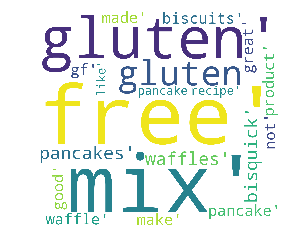


Cluster 1:
 tea
 green
 green tea
 not
 like
 teas
 drink
 iced
 love
 taste
 water
 iced tea
 flavor
 good
 great
 drinking
 sweet
 tea not
 use
 love tea


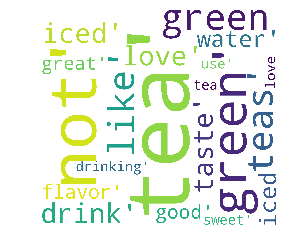


Cluster 2:
 coffee
 not
 cup
 decaf
 like
 taste
 smooth
 good
 bitter
 strong
 cup coffee
 one
 flavor
 dark
 roast
 bold
 blend
 melitta
 drink
 great


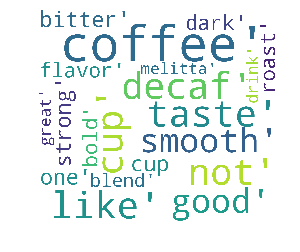


Cluster 3:
 food
 dog
 dog food
 dogs
 newman
 not
 cat
 loves
 organic
 one
 eat
 old
 no
 foods
 like
 cats
 quality
 year
 good
 dry


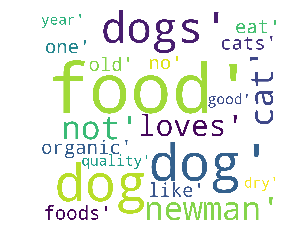


Cluster 4:
 chocolate
 hot
 cocoa
 hot chocolate
 cup
 hot cocoa
 not
 cups
 keurig
 dark
 dark chocolate
 taste
 milk
 grove
 good
 tried
 best
 grove square
 square
 like


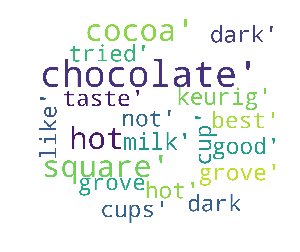


Cluster 5:
 not
 product
 great
 good
 like
 love
 one
 taste
 would
 flavor
 buy
 price
 really
 amazon
 use
 find
 no
 get
 little
 best


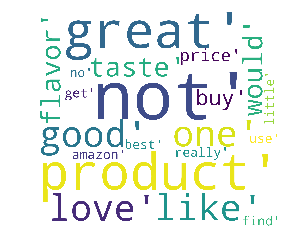


Cluster 6:
 chips
 salt
 not
 potato
 bag
 kettle
 flavor
 potato chips
 great
 vinegar
 like
 flavors
 love
 good
 bags
 salt vinegar
 chip
 taste
 snack
 popchips


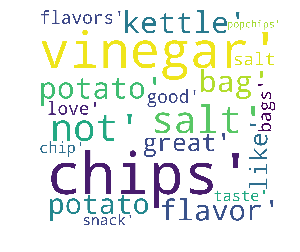

In [99]:
# Please write all the code with proper documentation
#orinting top 20 important words per cluster
print("Top terms per cluster:")
order_centroids = k_.cluster_centers_.argsort()[:, ::-1]
terms = tf_idf_vect.get_feature_names()
for i in range(7):
    print ("Cluster %d:" % i)
    words= []
    for ind in order_centroids[i, :20]:
        print (' %s' % terms[ind])
        words.append(terms[ind])
    print_words(str(words))
        
    print()

cluster 1 is about bakery items like cakes busicuits pan cakes ect
cluster 2 is about tea like green tea, iced tea
cluster 3 is about coffee like meliita,dtong coffe
cluster 4 is about animals where we see dogs and cats
cluster 5 is about chocolates
cluster 6 is about positive words except the word not
cluster 7 is about chips

### [5.1.5] Applying K-Means Clustering on AVG W2V,<font color='red'> SET 3</font>

In [100]:
# Please write all the code with proper documentation

cluster_range = range( 1, 20)
cluster_errors = []

for num_clusters in cluster_range:
    clusters = KMeans( num_clusters,n_init=5,n_jobs=-1)
    clusters.fit( sent_vectors)
    print('for k',num_clusters,'intertia', clusters.inertia_ )
    cluster_errors.append( clusters.inertia_ )

for k 1 intertia 653.2637811755627
for k 2 intertia 463.64777065052374
for k 3 intertia 376.19962492808816
for k 4 intertia 297.60921095044
for k 5 intertia 257.840200169866
for k 6 intertia 230.8636352213103
for k 7 intertia 208.04195832807258
for k 8 intertia 190.92933327159918
for k 9 intertia 178.0579440962419
for k 10 intertia 168.3652427374818
for k 11 intertia 160.9233623499699
for k 12 intertia 154.03805798293155
for k 13 intertia 148.52280561880224
for k 14 intertia 142.65766147631166
for k 15 intertia 138.1392148315555
for k 16 intertia 133.7185803538491
for k 17 intertia 130.24153772971553
for k 18 intertia 126.27914348327764
for k 19 intertia 123.65506407748188


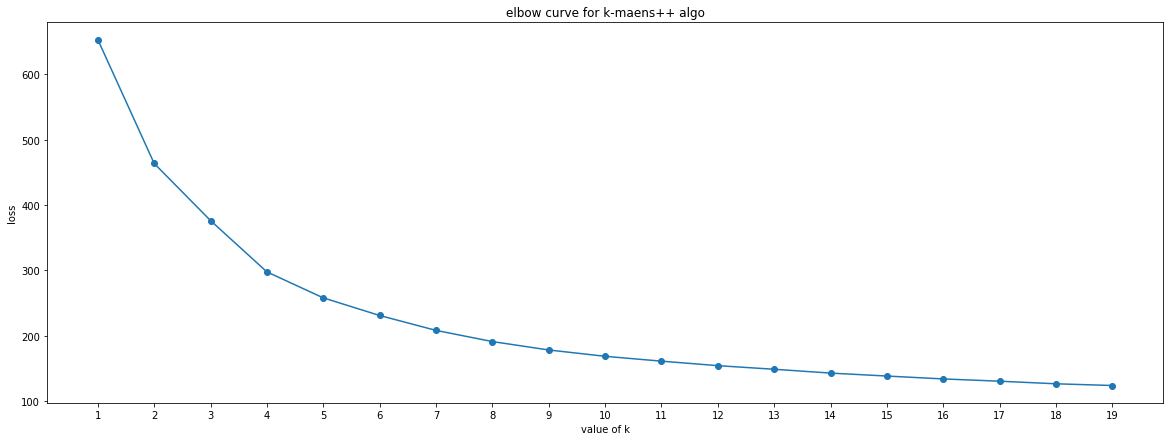

In [102]:
clusters_df_tf = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20,7))
plt.plot( list(range(1,20)), clusters_df_tf.cluster_errors, marker = "o" )
plt.xticks(list(range(1,20)))
plt.title('elbow curve for k-maens++ algo')
plt.xlabel('value of k')
plt.ylabel('loss')
plt.show()

taking k as 4

In [103]:
k_avg = KMeans(n_clusters=4, random_state = 0).fit(sent_vectors)

### [5.1.6] Wordclouds of clusters obtained after applying k-means on AVG W2V<font color='red'> SET 3</font>

In [105]:
# Getting all the reviews in different clusters
#below function taken from https://github.com/PushpendraSinghChauhan/Amazon-Fine-Food-Reviews/blob/master/Apply%20clustering%20%20on%20Amazon%20Food%20Reviews.ipynb
reviews = preprocessed_reviews
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []

for i in range(k_avg.labels_.shape[0]):
    if k_avg.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif k_avg.labels_[i] == 1:
        cluster2.append(reviews[i])
    elif k_avg.labels_[i] == 2:
        cluster3.append(reviews[i])
    else :
        cluster4.append(reviews[i]) 
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))

No. of reviews in Cluster-1 :  1373

No. of reviews in Cluster-2 :  2099

No. of reviews in Cluster-3 :  1499

No. of reviews in Cluster-4 :  15


Review-1 : 
 used victor fly bait seasons ca not beat great product

Review-2 : 
 using food months find excellent fact two dogs coton de tulear standard poodle puppy love food thriving coats excellent condition overall structure perfect good tasting dog good good deal owner around best food ever used excellent

Review-3 : 
 bought brand online indian grocery store usually excellent products able turn cream butter using super blender adding water barely flavor usually buy chao kah brand coconut cream quite tasty flavorful read another review different product making coconut cream complaint not shreds texture mine virtually tasteless



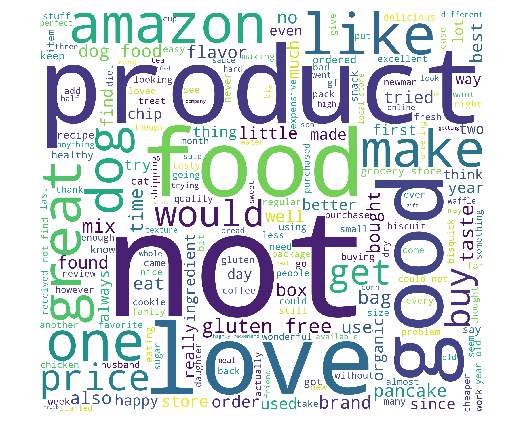

In [111]:
# Three Reviews of cluster 1
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster1[i]))
    count +=1
print_words(str(cluster1))

Review-2 : 
 product available victor traps unreal course total fly genocide pretty stinky right nearby

Review-3 : 
 received shipment could hardly wait try product love slickers call instead stickers removed easily daughter designed signs printed reverse use car windows printed beautifully print shop program going lot fun product windows everywhere surfaces like tv screens computer monitors

Review-4 : 
 really good idea final product outstanding use decals car window everybody asks bought decals made two thumbs



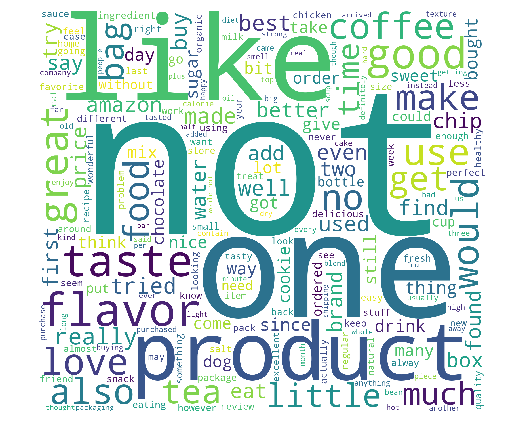

In [112]:
# Three Reviews of cluster 2
count=2
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster2[i]))
    count +=1
print_words(str(cluster2))

Review-1 : 
 mix probably not something would want use everyday new enough different enough something special add summertime recipe want reward something fun fruity fill bill quickly easily no aftertaste often associated diet drinks highly recommend

Review-2 : 
 love pico pica adds flavor not hot eat least meals every day good eggs good pizza good vegetables really not go wrong

Review-3 : 
 not good yummy smell like cloves cooking taste little sweet



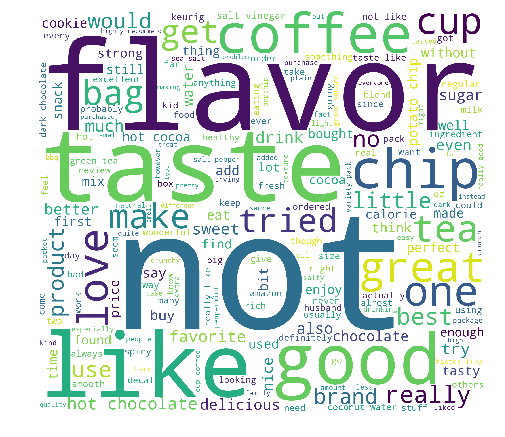

In [113]:
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster3[i]))
    count +=1
print_words(str(cluster3))

we are not getting good seperation

### [5.1.7] Applying K-Means Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [115]:
# Please write all the code with proper documentation

cluster_range = range( 1, 20)
cluster_errors = []

for num_clusters in cluster_range:
    clusters = KMeans( num_clusters,n_init=5,n_jobs=-1)
    clusters.fit(tfidf_sent_vectors)
    print('for k',num_clusters,'intertia', clusters.inertia_ )
    cluster_errors.append( clusters.inertia_ )



for k 1 intertia 934.2187134540811
for k 2 intertia 590.1370340814775
for k 3 intertia 488.62926464498014
for k 4 intertia 401.62709787566297
for k 5 intertia 346.32225474601853
for k 6 intertia 309.1099128555991
for k 7 intertia 274.886309127054
for k 8 intertia 252.23105804484217
for k 9 intertia 233.43146255223473
for k 10 intertia 220.31788280767626
for k 11 intertia 208.8639426256132
for k 12 intertia 198.07441600308425
for k 13 intertia 188.76617705322138
for k 14 intertia 180.3071576453923
for k 15 intertia 171.95274945289032
for k 16 intertia 165.1132247927928
for k 17 intertia 159.35366704901892
for k 18 intertia 153.24678456089055
for k 19 intertia 148.99432853485104


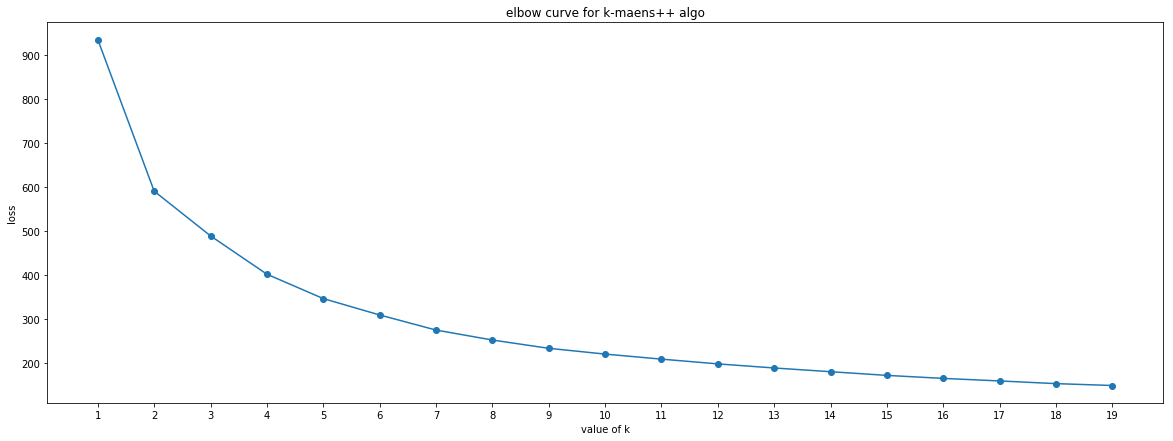

In [116]:
clusters_df_tfa = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20,7))
plt.plot( list(range(1,20)), clusters_df_tfa.cluster_errors, marker = "o" )
plt.xticks(list(range(1,20)))
plt.title('elbow curve for k-maens++ algo')
plt.xlabel('value of k')
plt.ylabel('loss')
plt.show()

taking k valus as 3

In [119]:
k_avg_tf = KMeans(n_clusters=3, random_state = 0).fit(tfidf_sent_vectors)

### [5.1.8] Wordclouds of clusters obtained after applying k-means on TFIDF W2V<font color='red'> SET 4</font>

In [120]:
# Please write all the code with proper documentation

cluster1 = []
cluster2 = []
cluster3 = []

for i in range(k_avg.labels_.shape[0]):
    if k_avg.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif k_avg.labels_[i] == 1:
        cluster2.append(reviews[i])
   
    else :
        cluster3.append(reviews[i]) 
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))
#print("\nNo. of reviews in Cluster-4 : ",len(cluster4))

No. of reviews in Cluster-1 :  1373

No. of reviews in Cluster-2 :  2099

No. of reviews in Cluster-3 :  1514


Review-1 : 
 used victor fly bait seasons ca not beat great product

Review-2 : 
 using food months find excellent fact two dogs coton de tulear standard poodle puppy love food thriving coats excellent condition overall structure perfect good tasting dog good good deal owner around best food ever used excellent

Review-3 : 
 bought brand online indian grocery store usually excellent products able turn cream butter using super blender adding water barely flavor usually buy chao kah brand coconut cream quite tasty flavorful read another review different product making coconut cream complaint not shreds texture mine virtually tasteless



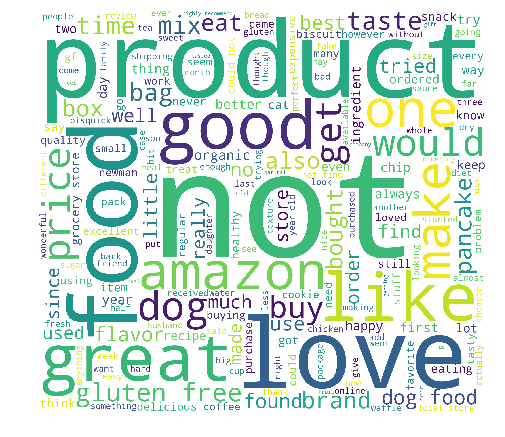

In [121]:
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster1[i]))
    count +=1
print_words(str(cluster1))

Review-1 : 
 product available victor traps unreal course total fly genocide pretty stinky right nearby

Review-2 : 
 received shipment could hardly wait try product love slickers call instead stickers removed easily daughter designed signs printed reverse use car windows printed beautifully print shop program going lot fun product windows everywhere surfaces like tv screens computer monitors

Review-3 : 
 really good idea final product outstanding use decals car window everybody asks bought decals made two thumbs



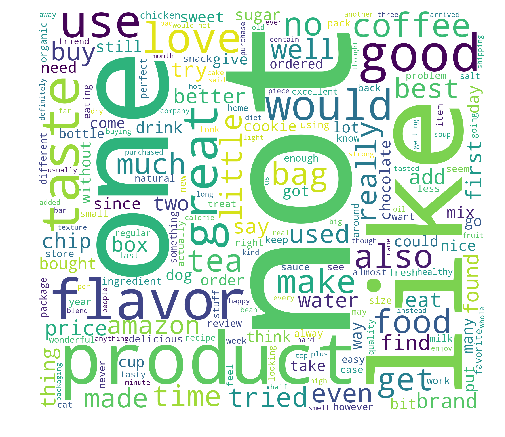

In [122]:
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster2[i]))
    count +=1
print_words(str(cluster2))

Review-1 : 
 mix probably not something would want use everyday new enough different enough something special add summertime recipe want reward something fun fruity fill bill quickly easily no aftertaste often associated diet drinks highly recommend

Review-2 : 
 love pico pica adds flavor not hot eat least meals every day good eggs good pizza good vegetables really not go wrong

Review-3 : 
 



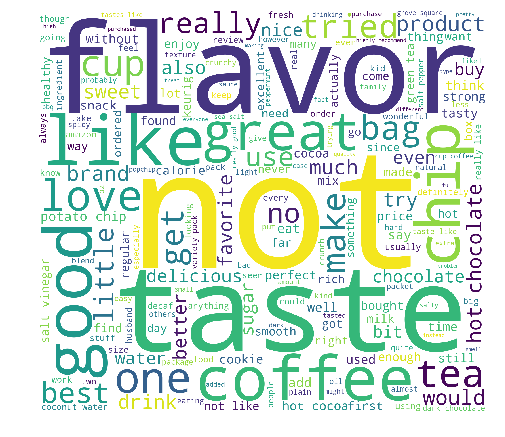

In [123]:
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster3[i]))
    count +=1
print_words(str(cluster3))

we  v=can see some seperation like cluster 1 is about bakery items like biscuit pancake.cluster 2 about tea and coffeee

## [5.2] Agglomerative Clustering

### [5.2.1] Applying Agglomerative Clustering on AVG W2V,<font color='red'> SET 3</font>

In [124]:
# Please write all the code with proper documentation
#two clusters
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=2).fit(sent_vectors)
agg_4 = AgglomerativeClustering(n_clusters=4).fit(sent_vectors)

agg_8 = AgglomerativeClustering(n_clusters=8).fit(sent_vectors)


### [5.2.2] Wordclouds of clusters obtained after applying Agglomerative Clustering on AVG W2V<font color='red'> SET 3</font>

In [ ]:
cluster1 = []
cluster2 = []

for i in range(agg.labels_.shape[0]):
    if agg.labels_[i] == 0:
        cluster1.append(reviews[i])
    else :
        cluster2.append(reviews[i])
 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
count=1
for i in range(3):
    if i < len(cluster1):
        print('Review-%d : \n %s\n'%(count,cluster1[i]))
        count +=1
print_words(str(cluster1))       

Review-1 : 
 received shipment could hardly wait try product love slickers call instead stickers removed easily daughter designed signs printed reverse use car windows printed beautifully print shop program going lot fun product windows everywhere surfaces like tv screens computer monitors

Review-2 : 
 really good idea final product outstanding use decals car window everybody asks bought decals made two thumbs

Review-3 : 
 glad cocker standard poodle puppy loves stuff trust brand superior nutrition compare labels previous feed pedigree mostly corn little dude healthy happy high energy glossy coat also superior nutrition produces smaller compact stools



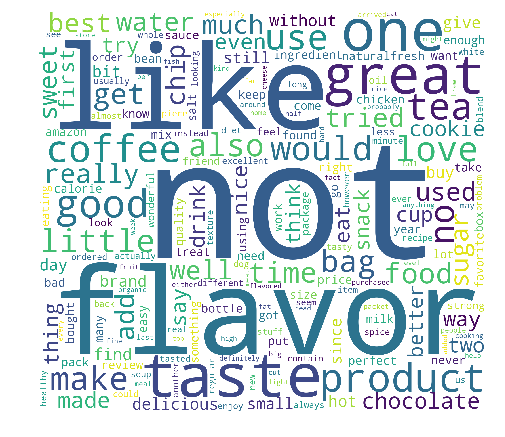

In [129]:
count=1
for i in range(3):
    if i < len(cluster2):
        print('Review-%d : \n %s\n'%(count,cluster2[i]))
        count +=1
print_words(str(cluster2)) 

not getting good seperation .lrts check 4 clusters

No. of reviews in Cluster-1 :  2254

No. of reviews in Cluster-2 :  1181
No. of reviews in Cluster-3 :  1536

No. of reviews in Cluster-4 :  3450
Review-1 : 
 product available victor traps unreal course total fly genocide pretty stinky right nearby

Review-2 : 
 used victor fly bait seasons ca not beat great product

Review-3 : 
 using food months find excellent fact two dogs coton de tulear standard poodle puppy love food thriving coats excellent condition overall structure perfect good tasting dog good good deal owner around best food ever used excellent



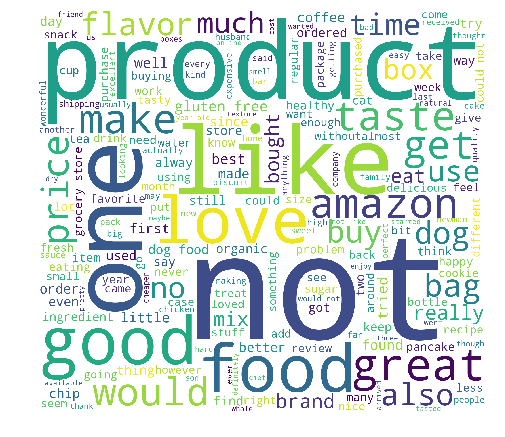

In [131]:
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
for i in range(agg_4.labels_.shape[0]):
    if agg_4.labels_[i] == 0:
        cluster1.append(reviews[i])
    if agg_4.labels_[i] == 1:
        cluster2.append(reviews[i])
    if agg_4.labels_[i] == 2:
        cluster3.append(reviews[i])
    
    else :
        cluster4.append(reviews[i])
 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("No. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))
count=1
for i in range(3):
    if i < len(cluster1):
        print('Review-%d : \n %s\n'%(count,cluster1[i]))
        count +=1
print_words(str(cluster1))  

Review-1 : 
 received shipment could hardly wait try product love slickers call instead stickers removed easily daughter designed signs printed reverse use car windows printed beautifully print shop program going lot fun product windows everywhere surfaces like tv screens computer monitors

Review-2 : 
 really good idea final product outstanding use decals car window everybody asks bought decals made two thumbs

Review-3 : 
 glad cocker standard poodle puppy loves stuff trust brand superior nutrition compare labels previous feed pedigree mostly corn little dude healthy happy high energy glossy coat also superior nutrition produces smaller compact stools



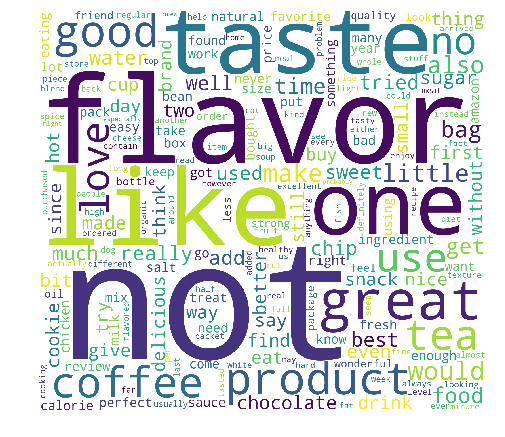

In [132]:
count=1
for i in range(3):
    if i < len(cluster2):
        print('Review-%d : \n %s\n'%(count,cluster2[i]))
        count +=1
print_words(str(cluster2))  

Review-1 : 
 received shipment could hardly wait try product love slickers call instead stickers removed easily daughter designed signs printed reverse use car windows printed beautifully print shop program going lot fun product windows everywhere surfaces like tv screens computer monitors

Review-2 : 
 really good idea final product outstanding use decals car window everybody asks bought decals made two thumbs

Review-3 : 
 glad cocker standard poodle puppy loves stuff trust brand superior nutrition compare labels previous feed pedigree mostly corn little dude healthy happy high energy glossy coat also superior nutrition produces smaller compact stools



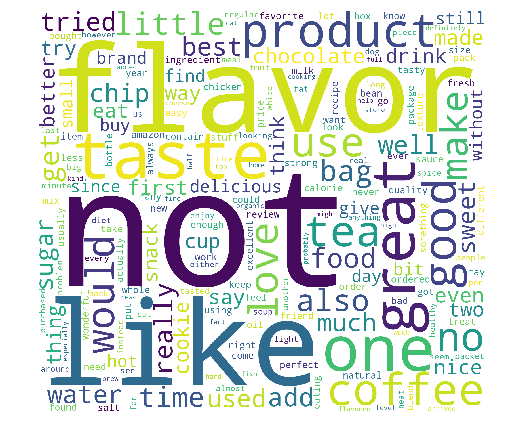

In [133]:
count=1
for i in range(3):
    if i < len(cluster2):
        print('Review-%d : \n %s\n'%(count,cluster2[i]))
        count +=1
print_words(str(cluster2))  

Review-1 : 
 love pico pica adds flavor not hot eat least meals every day good eggs good pizza good vegetables really not go wrong

Review-2 : 
 not good yummy smell like cloves cooking taste little sweet

Review-3 : 
 good stuff like lentils not need soak small feel good mouth



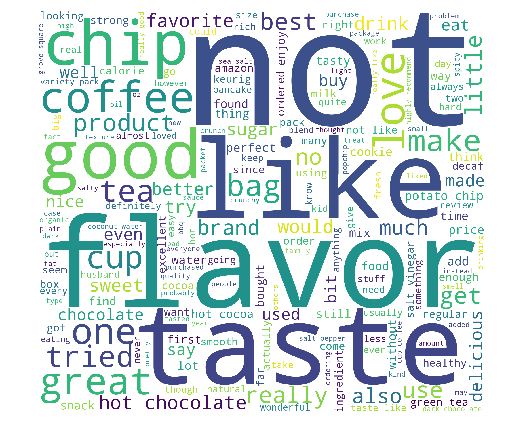

In [134]:
count=1
for i in range(3):
    if i < len(cluster3):
        print('Review-%d : \n %s\n'%(count,cluster3[i]))
        count +=1
print_words(str(cluster3))  

better than 2 lets see 8

In [138]:
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []
cluster6 = []
cluster7 = []
cluster8 = []
for i in range(agg_8.labels_.shape[0]):
    if agg_8.labels_[i] == 0:
        cluster1.append(reviews[i])
    if agg_8.labels_[i] == 1:
        cluster2.append(reviews[i])
    if agg_8.labels_[i] == 2:
        cluster3.append(reviews[i])
    if agg_8.labels_[i] == 3:
        cluster4.append(reviews[i])
    if agg_8.labels_[i] == 4:
        cluster5.append(reviews[i])
    if agg_8.labels_[i] == 5:
        cluster6.append(reviews[i])
    if agg_8.labels_[i] == 6:
        cluster7.append(reviews[i])
   
    else :
        cluster8.append(reviews[i])
 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("No. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))
print("No. of reviews in Cluster-5 : ",len(cluster5))
print("\nNo. of reviews in Cluster-6 : ",len(cluster6))
print("No. of reviews in Cluster-7 : ",len(cluster7))
print("\nNo. of reviews in Cluster-8 : ",len(cluster8))


No. of reviews in Cluster-1 :  1763

No. of reviews in Cluster-2 :  504
No. of reviews in Cluster-3 :  1032

No. of reviews in Cluster-4 :  617
No. of reviews in Cluster-5 :  564

No. of reviews in Cluster-6 :  172
No. of reviews in Cluster-7 :  319

No. of reviews in Cluster-8 :  4667


words for cluster-1 : 



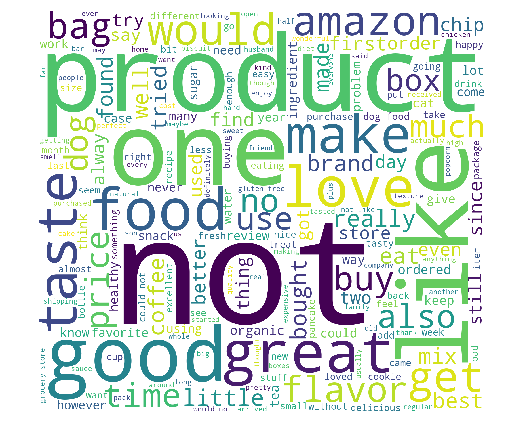

words for cluster-2 : 



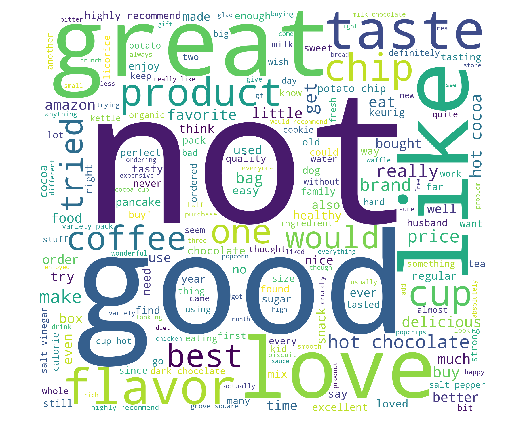

words for cluster-3 : 



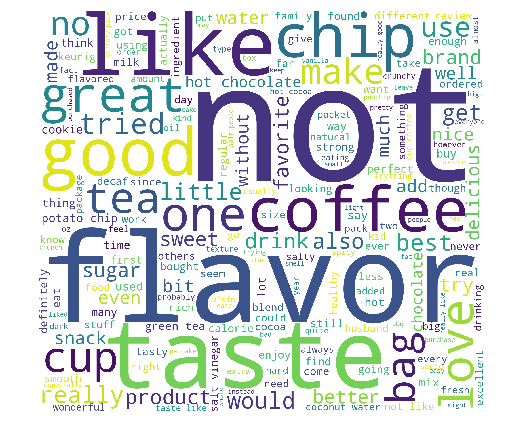

words for cluster-4 : 



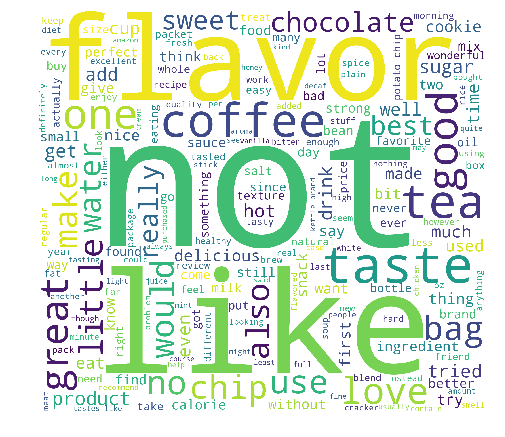

words for cluster-5 : 



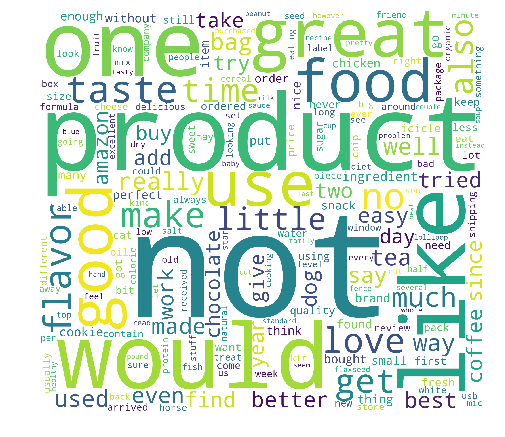

words for cluster-6 : 



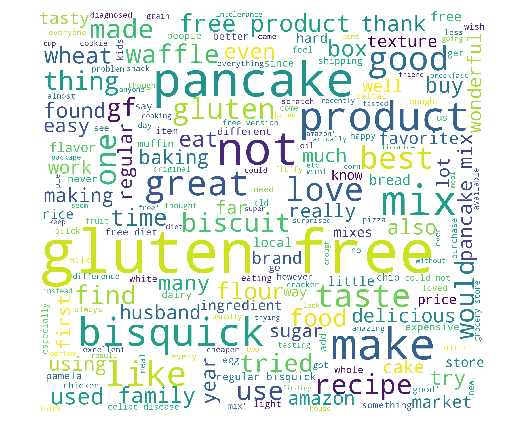

words for cluster-7 : 



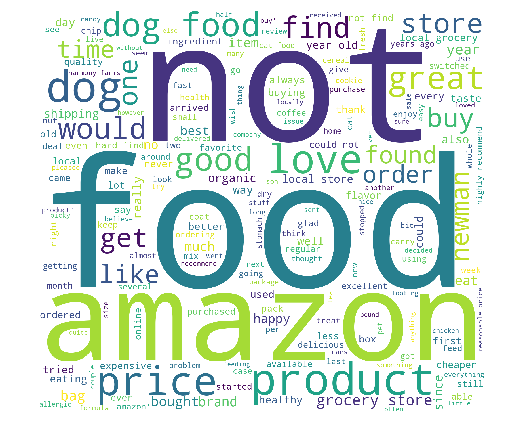

words for cluster-8 : 



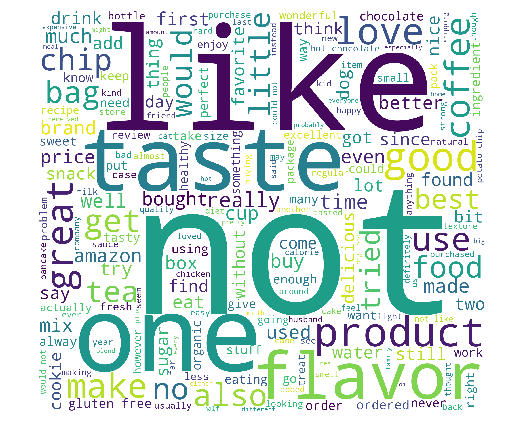

In [142]:
count=1
clusters = [cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7,cluster8]
for x in clusters:
    print('words for cluster-%d : \n'%(count))
    print_words(str(x))
    count +=1

In [3]:
we can see some good seperation

### [5.2.3] Applying Agglomerative Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [143]:
# Please write all the code with proper documentation

ag = AgglomerativeClustering(n_clusters=2).fit(tfidf_sent_vectors)


In [146]:
ag_4 = AgglomerativeClustering(n_clusters=4).fit(tfidf_sent_vectors)

In [149]:
ag_8 = AgglomerativeClustering(n_clusters=8).fit(tfidf_sent_vectors)

### [5.2.4] Wordclouds of clusters obtained after applying Agglomerative Clustering on TFIDF W2V<font color='red'> SET 4</font>

No. of reviews in Cluster-1 :  3558

No. of reviews in Cluster-2 :  1428
Review-1 : 
 using food months find excellent fact two dogs coton de tulear standard poodle puppy love food thriving coats excellent condition overall structure perfect good tasting dog good good deal owner around best food ever used excellent

Review-2 : 
 mix probably not something would want use everyday new enough different enough something special add summertime recipe want reward something fun fruity fill bill quickly easily no aftertaste often associated diet drinks highly recommend

Review-3 : 
 description product disceptive product represented powder not powder granule nothing shredded coconut not even dissolve high speed commercial blender unless using product manufacture dark chocolate coated coconut patty useless intention use additive healthy shake ended ruining shake resort chewing undissolved tasteless coconut pieces rather drinking shake additionally way product packaged no protective cardboard pr

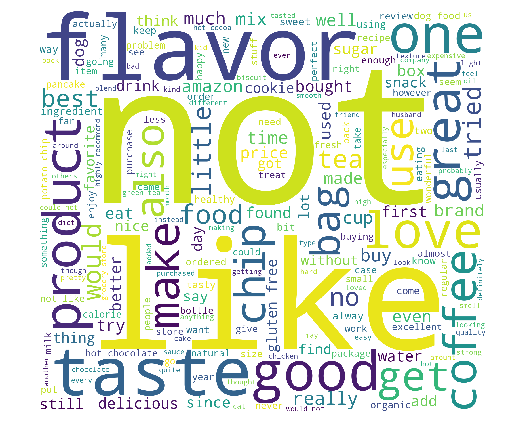

In [144]:
# Please write all the code with proper documentation

cluster1 = []
cluster2 = []

for i in range(ag.labels_.shape[0]):
    if ag.labels_[i] == 0:
        cluster1.append(reviews[i])
    else :
        cluster2.append(reviews[i])
 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
count=1
for i in range(3):
    if i < len(cluster1):
        print('Review-%d : \n %s\n'%(count,cluster1[i]))
        count +=1
print_words(str(cluster1))  

Review-1 : 
 product available victor traps unreal course total fly genocide pretty stinky right nearby

Review-2 : 
 used victor fly bait seasons ca not beat great product

Review-3 : 
 received shipment could hardly wait try product love slickers call instead stickers removed easily daughter designed signs printed reverse use car windows printed beautifully print shop program going lot fun product windows everywhere surfaces like tv screens computer monitors



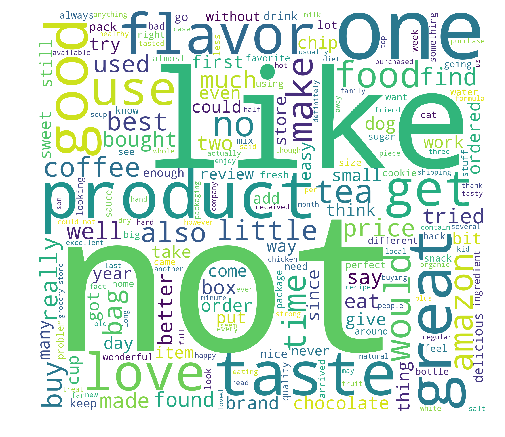

In [145]:
count=1
for i in range(3):
    if i < len(cluster2):
        print('Review-%d : \n %s\n'%(count,cluster2[i]))
        count +=1
print_words(str(cluster2))  

not getting good grouping.lets see 4 clusters

cluster-1 words : 
 


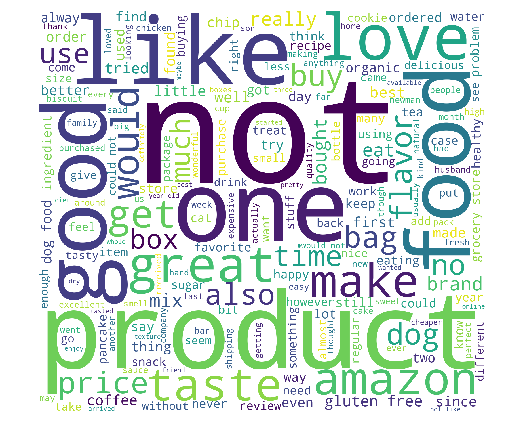

cluster-2 words : 
 


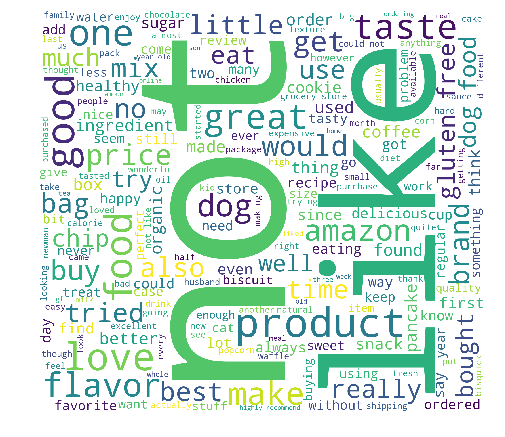

cluster-3 words : 
 


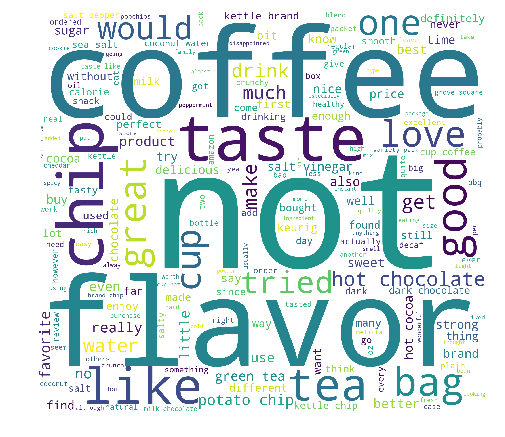

cluster-4 words : 
 


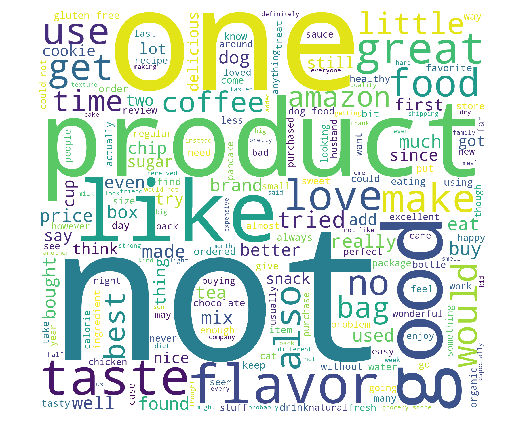

In [148]:
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
for i in range(ag_4.labels_.shape[0]):
    if agg_4.labels_[i] == 0:
        cluster1.append(reviews[i])
    if ag_4.labels_[i] == 1:
        cluster2.append(reviews[i])
    if ag_4.labels_[i] == 2:
        cluster3.append(reviews[i])
    
    else :
        cluster4.append(reviews[i])
 
        
clusters = [cluster1,cluster2,cluster3,cluster4]

count=1
for i in clusters:
    
        print('cluster-%d words : \n '%(count))
        count +=1
        print_words(str(i))  

some what better.lets see 8 clusters

No. of reviews in Cluster-1 :  1146

No. of reviews in Cluster-2 :  1218
No. of reviews in Cluster-3 :  667

No. of reviews in Cluster-4 :  443
No. of reviews in Cluster-5 :  15

No. of reviews in Cluster-6 :  84
No. of reviews in Cluster-7 :  322

No. of reviews in Cluster-8 :  4664
words for cluster-1 : 



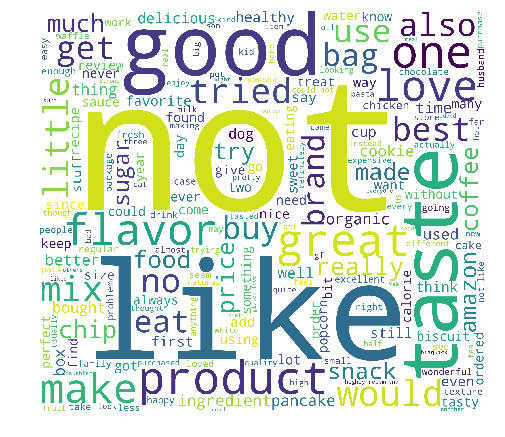

words for cluster-2 : 



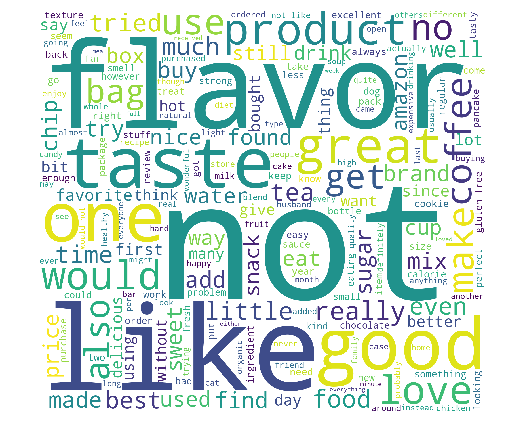

words for cluster-3 : 



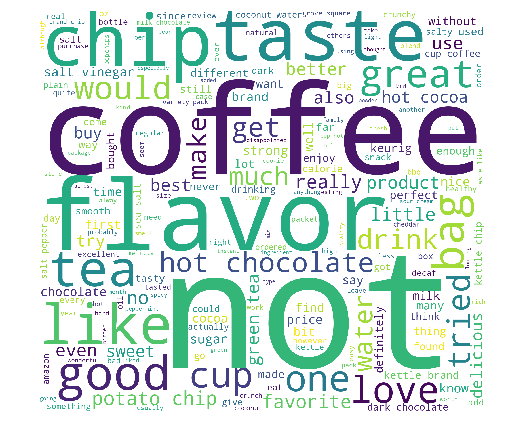

words for cluster-4 : 



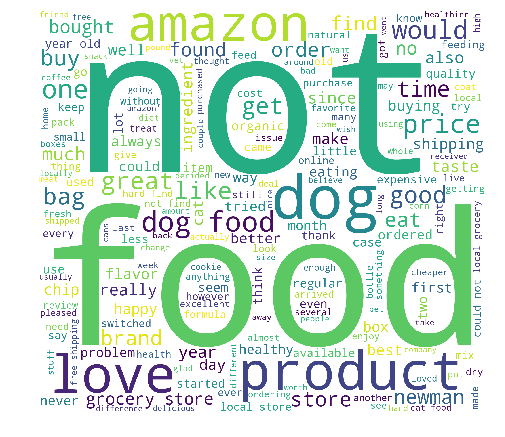

words for cluster-5 : 



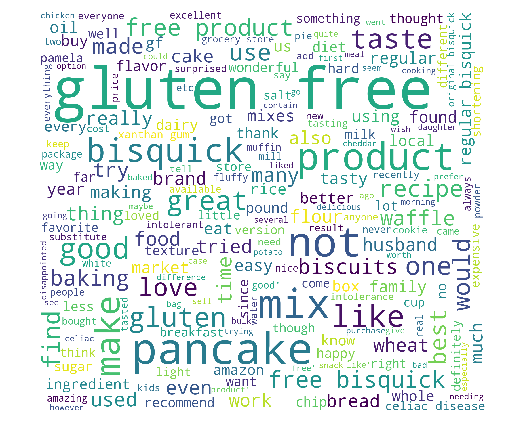

words for cluster-6 : 



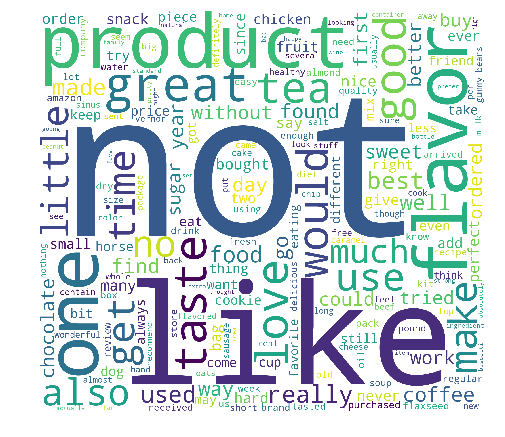

words for cluster-7 : 



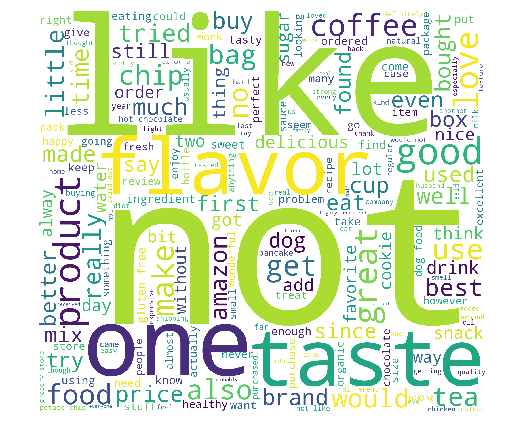

In [174]:
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []
cluster6 = []
cluster7 = []
cluster8 = []
for i in range(ag_8.labels_.shape[0]):
    if ag_8.labels_[i] == 0:
        cluster1.append(reviews[i])
    if ag_8.labels_[i] == 1:
        cluster2.append(reviews[i])
    if ag_8.labels_[i] == 2:
        cluster3.append(reviews[i])
    if ag_8.labels_[i] == 3:
        cluster4.append(reviews[i])
    if ag_8.labels_[i] == 4:
        cluster5.append(reviews[i])
    if ag_8.labels_[i] == 5:
        cluster6.append(reviews[i])
    if ag_8.labels_[i] == 6:
        cluster7.append(reviews[i])
   
    else :
        cluster8.append(reviews[i])
 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("No. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))
print("No. of reviews in Cluster-5 : ",len(cluster5))
print("\nNo. of reviews in Cluster-6 : ",len(cluster6))
print("No. of reviews in Cluster-7 : ",len(cluster7))
print("\nNo. of reviews in Cluster-8 : ",len(cluster8))

count=1
clusters = [cluster1,cluster2,cluster3,cluster4,cluster6,cluster7,cluster8]
for x in clusters:
    print('words for cluster-%d : \n'%(count))
    print_words(str(x))
    count +=1

we are getting good seperation

## [5.3] DBSCAN Clustering

### [5.3.1] Applying DBSCAN on AVG W2V,<font color='red'> SET 3</font>

In [162]:
# Please write all the code with proper documentation
#minpoint as 2*d,d is dmensionality of inout
min_points = 2*np.array(sent_vectors).shape[1]
min_points

100

In [157]:
#function to calculate distabce
def distance(vectors , n_points):
    distance = []
    for point in vectors:
        temp = np.sort(np.sum((vectors-point)**2,axis=1),axis=None)
        distance.append(temp[n_points])
    return np.sqrt(np.array(distance))

In [158]:
# Function definition for implementing DBSCAN
def dbscan(epsilon, samples, Data):
    from sklearn.cluster import DBSCAN
    db = DBSCAN(eps=epsilon, min_samples=samples, n_jobs=-1).fit(Data)
    
    # Number of clusters in labels, ignoring noise(-1) if present.
    n_clusters = len(set(db.labels_))
    print("Number of clusters for MinPts = %d and Epsilon = %f is : %d "%(samples,epsilon,n_clusters))
    print("Labels(-1 is for Noise) : ",set(db.labels_))
    print()
    return db

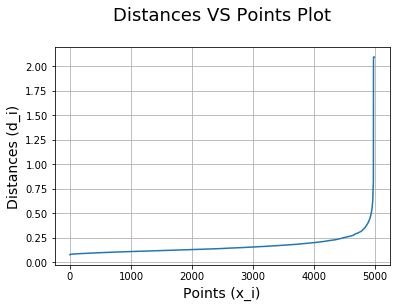

In [161]:

# Computing distances of nth-nearest neighbours
distances = distance(sent_vectors,min_points)
sorted_distance = np.sort(distances)
points = [i for i in range(np.array(sent_vectors).shape[0])]

# Draw distances(d_i) VS points(x_i) plot
plt.plot(points, sorted_distance)
plt.xlabel('Points (x_i)',size=14)
plt.ylabel('Distances (d_i)',size=14)
plt.title('Distances VS Points Plot\n',size=18)
plt.grid()
plt.show()

taking eps as 0.4

In [164]:
db1 = dbscan(0.4, min_points, sent_vectors)

Number of clusters for MinPts = 100 and Epsilon = 0.400000 is : 2 
Labels(-1 is for Noise) :  {0, -1}



### [5.3.2] Wordclouds of clusters obtained after applying DBSCAN on AVG W2V<font color='red'> SET 3</font>

No. of reviews in Cluster-1 :  4962

No. of reviews in Cluster-2 :  24
Review-1 : 
 product available victor traps unreal course total fly genocide pretty stinky right nearby

Review-2 : 
 used victor fly bait seasons ca not beat great product

Review-3 : 
 received shipment could hardly wait try product love slickers call instead stickers removed easily daughter designed signs printed reverse use car windows printed beautifully print shop program going lot fun product windows everywhere surfaces like tv screens computer monitors



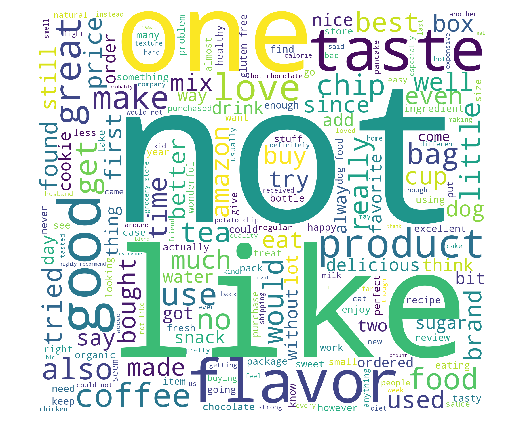

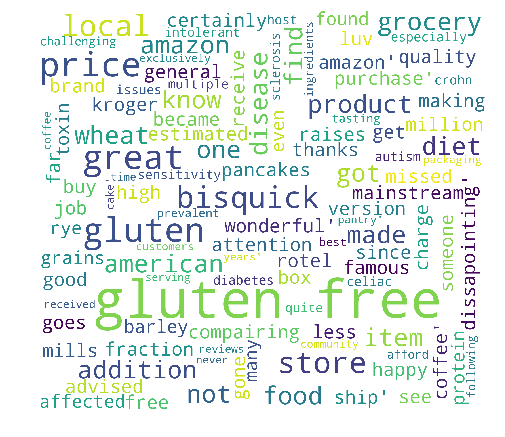

In [172]:
# Please write all the code with proper documentation
cluster1 = []
cluster2 = []

for i in range(db1.labels_.shape[0]):
    if db1.labels_[i] == 0:
        cluster1.append(reviews[i])
    else :
        cluster2.append(reviews[i])
 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
count=1
for i in range(3):
    if i < len(cluster1):
        print('Review-%d : \n %s\n'%(count,cluster1[i]))
        count +=1
print_words(str(cluster1)) 
print_words(str(cluster2))

In [ ]:
we can in cluster 2 we are getting grocery items grouping like wheat,barley,glutten etc

### [5.3.3] Applying DBSCAN on TFIDF W2V,<font color='red'> SET 4</font>

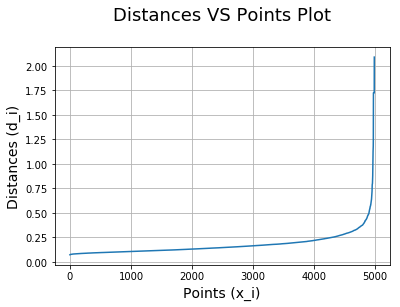

In [167]:
# Please write all the code with proper documentation
# Computing distances of nth-nearest neighbours
distances = distance(tfidf_sent_vectors,min_points)
sorted_distance = np.sort(distances)
points = [i for i in range(np.array(tfidf_sent_vectors).shape[0])]

# Draw distances(d_i) VS points(x_i) plot
plt.plot(points, sorted_distance)
plt.xlabel('Points (x_i)',size=14)
plt.ylabel('Distances (d_i)',size=14)
plt.title('Distances VS Points Plot\n',size=18)
plt.grid()
plt.show()

takmg eps as 0.5

In [169]:
db2 = dbscan(0.5, min_points, tfidf_sent_vectors)

Number of clusters for MinPts = 100 and Epsilon = 0.500000 is : 2 
Labels(-1 is for Noise) :  {0, -1}



### [5.3.4] Wordclouds of clusters obtained after applying DBSCAN on TFIDF W2V<font color='red'> SET 4</font>

No. of reviews in Cluster-1 :  4960

No. of reviews in Cluster-2 :  26
Review-1 : 
 product available victor traps unreal course total fly genocide pretty stinky right nearby

Review-2 : 
 used victor fly bait seasons ca not beat great product

Review-3 : 
 received shipment could hardly wait try product love slickers call instead stickers removed easily daughter designed signs printed reverse use car windows printed beautifully print shop program going lot fun product windows everywhere surfaces like tv screens computer monitors



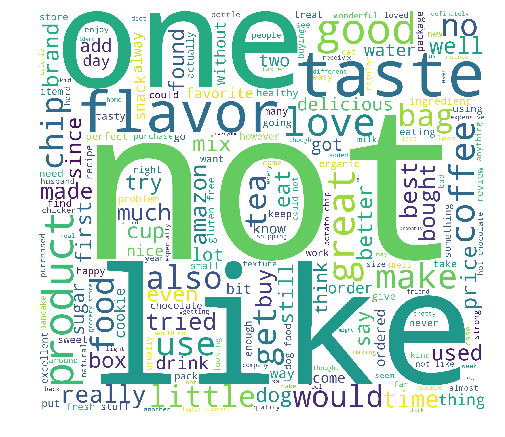

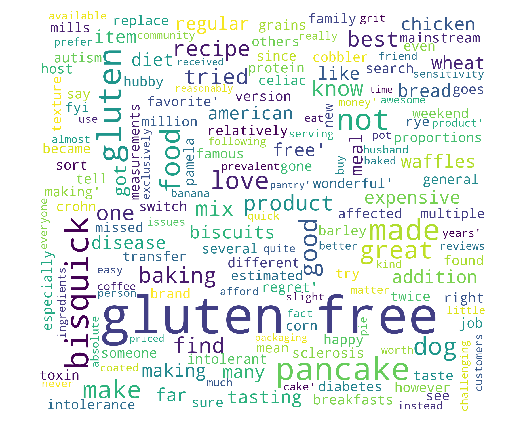

In [170]:
# Please write all the code with proper documentation

# Please write all the code with proper documentation
cluster1 = []
cluster2 = []

for i in range(db2.labels_.shape[0]):
    if db2.labels_[i] == 0:
        cluster1.append(reviews[i])
    else :
        cluster2.append(reviews[i])
 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
count=1
for i in range(3):
    if i < len(cluster1):
        print('Review-%d : \n %s\n'%(count,cluster1[i]))
        count +=1
print_words(str(cluster1)) 
print_words(str(cluster2))

here also we are getting grocery items clustering cluster 2

# [6] Conclusions

In [176]:
# Please compare all your models using Prettytable library. 
# You can have 3 tables, one each for kmeans, agllomerative and dbscan
#Kmeans
from prettytable import PrettyTable
x = PrettyTable()
x.field_names= ['Model','number of clusters','inertia']
x.add_row(['bag of words','8','245000'])
x.add_row(['tfidf','7','4700'])
x.add_row(['word2vec','4','250'])
x.add_row(['tfidf w2v','3','450'])
print(x)

+--------------+--------------------+---------+
|    Model     | number of clusters | inertia |
+--------------+--------------------+---------+
| bag of words |         8          |  245000 |
|    tfidf     |         7          |   4700  |
|   word2vec   |         4          |   250   |
|  tfidf w2v   |         3          |   450   |
+--------------+--------------------+---------+


In [177]:
# agllomerative
from prettytable import PrettyTable
x = PrettyTable()
x.field_names= ['Model','number of clusters']
x.add_row(['AVG W2v','2,4,8'])
x.add_row(['Tfidf w2v','2,4,8'])
print(x)

+-----------+--------------------+
|   Model   | number of clusters |
+-----------+--------------------+
|  AVG W2v  |       2,4,8        |
| Tfidf w2v |       2,4,8        |
+-----------+--------------------+


In [179]:
#dbscan
from prettytable import PrettyTable
x = PrettyTable()
x.field_names= ['Model','eps','number of clusters']
x.add_row(['AVG W2v','0.4','2'])
x.add_row(['Tfidf w2v','0.5','2'])
print(x)

+-----------+-----+--------------------+
|   Model   | eps | number of clusters |
+-----------+-----+--------------------+
|  AVG W2v  | 0.4 |         2          |
| Tfidf w2v | 0.5 |         2          |
+-----------+-----+--------------------+


**conclusion :** By using Tfidf and k means we are getting good separation